In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from stable_baselines3.common.vec_env import DummyVecEnv
# from sb3_contrib import RecurrentPPO
# from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import random
# from stable_baselines3.common.vec_env import SubprocVecEnv
# import matplotlib.pyplot as plt
# from typing import Tuple, Optional
import math
import mplfinance as mpf
from readAndSortCsv import read_and_sort_csv
from createSequences import create_sequences
from labelSequences import precompute_label_info, get_labels_from_precomputed
from plotData import plot_input_output_combined, plot_input_output_combined_with_label
from trades import compute_profit, compute_sharpe_ratio, compute_trading_statistics
from prepareScaledData import scale_X_0_1, encode_labels, compute_sample_profit, get_profitable_indices, get_flat_indices
from ta import trend, momentum, volatility, volume



In [2]:
# import pandas as pd
# import os
# import glob

# # Define the directory containing the CSV files
# csv_directory = r'E:\AICore\CnnTrading\CnnTrans\Data'  # Change this to your directory path

# # Define the required columns
# required_columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# # Use glob to get all CSV file paths
# csv_files = glob.glob(os.path.join(csv_directory, '*.csv'))

# # Initialize an empty list to hold individual DataFrames
# dataframes = []

# # Iterate over each CSV file
# for file in csv_files:
#     try:
#         # Read the CSV file
#         df = pd.read_csv(file)
#         # print(df.describe())
#         # Check if all required columns are present
#         if all(column in df.columns for column in required_columns):
#             # Select only the required columns
#             df = df[required_columns]
            
#             # Append the DataFrame to the list
#             dataframes.append(df)
#         else:
#             missing = list(set(required_columns) - set(df.columns))
#             print(f"Skipping {file}. Missing columns: {missing}")
#     except Exception as e:
#         print(f"Error reading {file}: {e}")

# # Concatenate all DataFrames
# if dataframes:
#     merged_df = pd.concat(dataframes, ignore_index=True)
    
#     # Convert 'date' column to datetime for proper merging
#     merged_df['date'] = pd.to_datetime(merged_df['date'])
    
#     # Drop duplicate dates if necessary (keeping the first occurrence)
#     merged_df = merged_df.drop_duplicates(subset=['date'], keep='first')
    
#     # Sort by date
#     merged_df = merged_df.sort_values(by='date', ascending=False).reset_index(drop=True)
    
#     # Save the merged DataFrame to a new CSV file
#     merged_df.to_csv('merged_output.csv', index=False)
    
#     print("CSV files have been successfully merged into 'merged_output.csv'.")
# else:
#     print("No valid CSV files found to merge.")


In [3]:
MODEL_PATH = 'simple1dcnn_state_dict.pth'
required_columns = ['date', 'open', 'high', 'low', 'close', 'volume']
file_path = r"C:\GitCnn\CnnTrading\CnnTrans\merged_output.csv"
input_window = 150
output_window = 15
np.set_printoptions(formatter={'float_kind': lambda x: f'{x:.2f}'})
random.seed(42)
np.random.seed(42)

# Read data and compute X, y, labels

In [4]:
# 1) Read & sort in descending order
df = read_and_sort_csv(file_path, required_columns)

# Assuming 'df' is your DataFrame with 'open', 'high', 'low', 'close', 'volume'

# Moving Averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

# RSI
df['RSI_14'] = momentum.RSIIndicator(close=df['close'], window=14).rsi()

# MACD
macd = trend.MACD(close=df['close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# Bollinger Bands
bollinger = volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# ATR
df['ATR_14'] = volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()

# OBV
df['OBV'] = volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()

# Stochastic Oscillator
stochastic = momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
df['Stochastic_%K'] = stochastic.stoch()
df['Stochastic_%D'] = stochastic.stoch_signal()

# Ichimoku Cloud
ichimoku = trend.IchimokuIndicator(high=df['high'], low=df['low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()
df['Ichimoku_Base_Line'] = ichimoku.ichimoku_base_line()
df['Ichimoku_Conversion_Line'] = ichimoku.ichimoku_conversion_line()

# Handle missing values
df.dropna(inplace=True)  # or df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame


In [5]:
df


,open,high,low,close,volume,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,...,Bollinger_Low,Bollinger_Middle,ATR_14,OBV,Stochastic_%K,Stochastic_%D,Ichimoku_A,Ichimoku_B,Ichimoku_Base_Line,Ichimoku_Conversion_Line
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:34:00,7176.24,7176.24,7175.42,7175.77,3.14500,7174.7275,7175.689302,49.533929,-0.389558,-0.882934,...,7170.600666,7174.7275,3.238610,-290.216000,57.990868,69.748858,7177.3050,7179.395,7179.395,7175.215
2020-01-01 00:35:00,7175.76,7175.76,7174.14,7174.14,26.80800,7174.5215,7175.541749,46.253894,-0.473266,-0.801000,...,7170.722246,7174.5215,3.123709,-317.024000,39.383562,53.652968,7177.3050,7179.395,7179.395,7175.215
2020-01-01 00:36:00,7174.66,7175.71,7174.66,7175.71,8.45000,7174.5305,7175.557773,49.708266,-0.408214,-0.722443,...,7170.720894,7174.5305,3.012730,-308.574000,57.305936,51.560122,7176.8800,7179.395,7178.060,7175.700
2020-01-01 00:37:00,7175.71,7175.92,7174.69,7175.76,14.27500,7174.6080,7175.577033,49.818882,-0.348606,-0.647676,...,7170.764712,7174.6080,2.885392,-294.299000,57.876712,51.522070,7176.4900,7179.395,7177.175,7175.805
2020-01-01 00:38:00,7175.76,7176.37,7175.76,7176.37,2.77500,7174.7835,7175.652553,51.228279,-0.249271,-0.567995,...,7170.954990,7174.7835,2.722864,-291.524000,63.636364,59.606337,7176.2750,7179.395,7176.430,7176.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26 23:55:00,95856.71,95856.71,95828.24,95828.25,2.59874,95790.5420,95781.792308,56.434153,30.676563,31.702057,...,95714.629499,95790.5420,49.493024,-537451.095175,75.907898,71.993177,95738.0000,95614.515,95678.355,95797.645
2024-12-26 23:56:00,95828.25,95839.06,95820.73,95838.58,2.68533,95794.8700,95787.200660,57.362873,31.496596,31.660965,...,95718.368219,95794.8700,47.267093,-537448.409845,84.652501,86.850645,95738.0000,95614.515,95678.355,95797.645
2024-12-26 23:57:00,95838.59,95838.59,95829.07,95829.07,4.81558,95802.3090,95791.188216,56.175598,31.021504,31.533073,...,95745.393446,95802.3090,44.570872,-537453.225425,76.602049,79.054149,95745.9975,95614.515,95694.350,95797.645


In [6]:
print(f"Successfully read {len(df)} rows from the CSV file.")
print("First few rows (asc):")
print(df.head(3))
print("Last few rows (asc):")
print(df.tail(3))

# 2) Create input/output sequences
# data = list(zip(*create_sequences(df, input_window=input_window, output_window=output_window, step=150)))
# np.random.shuffle(data)
# X, y = zip(*data)
# X, y = np.array(X), np.array(y)
# del data
X, y = create_sequences(df, input_window=input_window, output_window=output_window, step=150)


Successfully read 2621738 rows from the CSV file.
First few rows (asc):
                        open     high      low    close  volume     SMA_20  \
date                                                                         
2020-01-01 00:34:00  7176.24  7176.24  7175.42  7175.77   3.145  7174.7275   
2020-01-01 00:35:00  7175.76  7175.76  7174.14  7174.14  26.808  7174.5215   
2020-01-01 00:36:00  7174.66  7175.71  7174.66  7175.71   8.450  7174.5305   

                          EMA_20     RSI_14      MACD  MACD_Signal  ...  \
date                                                                ...   
2020-01-01 00:34:00  7175.689302  49.533929 -0.389558    -0.882934  ...   
2020-01-01 00:35:00  7175.541749  46.253894 -0.473266    -0.801000  ...   
2020-01-01 00:36:00  7175.557773  49.708266 -0.408214    -0.722443  ...   

                     Bollinger_Low  Bollinger_Middle    ATR_14      OBV  \
date                                                                      
2020-01-01 

In [7]:
X.shape

(17478, 150, 22)

In [8]:
def compute_labels_simple(
    X: np.ndarray, 
    y: np.ndarray, 
    close_idx: int = 3, 
    threshold: float = 0.03
) -> np.ndarray:
    """
    Computes labels based on the percentage difference between the last
    closing price of the input and output windows.

    Args:
        X: Input window data, shape (num_samples, input_window, num_features).
        y: Output window data, shape (num_samples, output_window, num_features).
        close_idx: Index of the closing price in the feature set.
        threshold: Percentage threshold to classify "long" or "short".

    Returns:
        labels: An array of labels ("long", "short", "flat"), shape (num_samples,).
    """
    num_samples = X.shape[0]
    labels = np.empty(num_samples, dtype=object)

    for i in range(num_samples):
        price_in_end = X[i, -1, close_idx]
        price_out_end = y[i, -1, close_idx]

        if price_in_end == 0:
            labels[i] = "flat"  # Avoid division by zero
            continue

        pct_diff = ((price_out_end - price_in_end) / price_in_end) * 100

        if pct_diff > threshold:
            labels[i] = "long"
        elif pct_diff < -threshold:
            labels[i] = "short"
        else:
            labels[i] = "flat"

    return labels


In [9]:
# # labels = label_sequences(X, y, close_idx=3, volume_idx=4, alpha=0.7, beta=0.3, threshold=1.0)
# (
#     direction_pct_arr,
#     range_diff_arr,
#     p_val_arr,
#     median_in_arr,
#     median_out_arr
# ) = precompute_label_info(X, y, close_idx=3, high_idx=1, low_idx=2, volume_idx=4)

# labels = get_labels_from_precomputed(
#     direction_pct_arr, range_diff_arr, p_val_arr, median_in_arr, median_out_arr,
#     alpha=1.469647214304428, beta=0.0054738562416353255, gamma=0, threshold=0.1426995297068393
# )
# #  {'alpha': 1.469647214304428, 'beta': 0.0054738562416353255, 'threshold': 0.1426995297068393}
labels = compute_labels_simple(X, y, threshold = 0.15)
print(f"\nCreated {X.shape[0]} input-output sequences.")
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

# 3) (Optional) Scale sequences ...

# 4) (Optional) Save sequences ...

# 5) Plot a sample input-output window on one chart


Created 17478 input-output sequences.
Input shape: (17478, 150, 22)
Output shape: (17478, 15, 22)


In [10]:
# np.save('X.npy', X)
# np.save('y.npy', y)
# np.save('labels.npy', labels)

# Load X, y, labels

In [11]:
train_percent = 0.8    # 80% for training
val_percent = 0.1      # 10% for validation
test_percent = 0.1     # 10% for testing

# Ensure that the percentages sum to 1
assert train_percent + val_percent + test_percent == 1.0, "Percentages must sum to 1."

# Calculate the number of samples
total_samples = len(X)
train_end = int(train_percent * total_samples)
val_end = train_end + int(val_percent * total_samples)

# Split the data
X_train_slice = X[:train_end]
y_train_slice = y[:train_end]
labels_train_slice = labels[:train_end]

X_val_slice = X[train_end:val_end]
y_val_slice = y[train_end:val_end]
labels_val_slice = labels[train_end:val_end]

X_test_slice = X[val_end:]
y_test_slice = y[val_end:]
labels_test_slice = labels[val_end:]

print("After Splitting:")
print(f"X_train_slice shape: {X_train_slice.shape}")
print(f"y_train_slice shape: {y_train_slice.shape}")
print(f"labels_train_slice shape: {labels_train_slice.shape}\n")

print(f"X_val_slice shape: {X_val_slice.shape}")
print(f"y_val_slice shape: {y_val_slice.shape}")
print(f"labels_val_slice shape: {labels_val_slice.shape}\n")

print(f"X_test_slice shape: {X_test_slice.shape}")
print(f"y_test_slice shape: {y_test_slice.shape}")
print(f"labels_test_slice shape: {labels_test_slice.shape}\n")

# Save the slices to disk
# np.save('X_train_slice.npy', X_train_slice)
# np.save('y_train_slice.npy', y_train_slice)
# np.save('labels_train_slice.npy', labels_train_slice)

# np.save('X_val_slice.npy', X_val_slice)
# np.save('y_val_slice.npy', y_val_slice)
# np.save('labels_val_slice.npy', labels_val_slice)

# np.save('X_test_slice.npy', X_test_slice)
# np.save('y_test_slice.npy', y_test_slice)
# np.save('labels_test_slice.npy', labels_test_slice)

# print("Data slices have been saved successfully.")


After Splitting:
X_train_slice shape: (13982, 150, 22)
y_train_slice shape: (13982, 15, 22)
labels_train_slice shape: (13982,)

X_val_slice shape: (1747, 150, 22)
y_val_slice shape: (1747, 15, 22)
labels_val_slice shape: (1747,)

X_test_slice shape: (1749, 150, 22)
y_test_slice shape: (1749, 15, 22)
labels_test_slice shape: (1749,)



In [12]:
# # Load the slices from disk
# X_train_slice = np.load('X_train_slice.npy')
# y_train_slice = np.load('y_train_slice.npy')
# labels_train_slice = np.load('labels_train_slice.npy')

# X_val_slice = np.load('X_val_slice.npy')
# y_val_slice = np.load('y_val_slice.npy')
# labels_val_slice = np.load('labels_val_slice.npy')

# X_test_slice = np.load('X_test_slice.npy')
# y_test_slice = np.load('y_test_slice.npy')
# labels_test_slice = np.load('labels_test_slice.npy')

# print("Data slices have been loaded successfully.")
# # Print shapes after loading
# print("After Loading:")
# print(f"X_train_loaded shape: {X_train_slice.shape}")
# print(f"y_train_loaded shape: {y_train_slice.shape}")
# print(f"labels_train_loaded shape: {labels_train_slice.shape}\n")

# print(f"X_val_loaded shape: {X_val_slice.shape}")
# print(f"y_val_loaded shape: {y_val_slice.shape}")
# print(f"labels_val_loaded shape: {labels_val_slice.shape}\n")

# print(f"X_test_loaded shape: {X_test_slice.shape}")
# print(f"y_test_loaded shape: {y_test_slice.shape}")
# print(f"labels_test_loaded shape: {labels_test_slice.shape}\n")

In [13]:
del X
del y
del labels

In [14]:
print(len(X_train_slice))
print(len(X_val_slice))
print(len(X_test_slice))

13982
1747
1749


# Tuning

In [15]:
# import optuna

# # Precompute once
# precomp = precompute_label_info(X, y, close_idx=3, high_idx=1, low_idx=2, volume_idx=4)

# def objective(trial, objective_name="profit"):
#     """
#     objective_name can be "profit" or "sharpe" to switch the metric.
#     """
#     # Example: fix alpha = 0, or let it vary
#     # alpha = 0
#     alpha = trial.suggest_float("alpha", -2.0, 2.0)
    
#     beta = trial.suggest_float("beta", -1.0, 1.0)
#     # gamma = trial.suggest_float("gamma", 0.0, 1.0)
#     gamma = 0
#     threshold = trial.suggest_float("threshold", 0.0, 1.0)

#     # Unpack precomputed
#     direction_pct_arr, range_diff_arr, p_val_arr, median_in_arr, median_out_arr = precomp
    
#     # Get labels quickly
#     labels = get_labels_from_precomputed(
#         direction_pct_arr, range_diff_arr, p_val_arr, median_in_arr, median_out_arr,
#         alpha=alpha, beta=beta, gamma=gamma, threshold=threshold
#     )
    
#     # Evaluate performance
#     if objective_name == "sharpe":
#         score = compute_sharpe_ratio(X, y, labels)
#         if score == 0: score = -10
#     else:
#         score = compute_profit(X, y, labels)
    
#     # We want to maximize the metric => minimize the negative
#     return -score

# # Create and run a study, e.g. for profit
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda t: objective(t, objective_name="profit"), n_trials=500)

# print("==== Profit Objective ====")
# print("Best params:", study.best_params)
# print("Max profit found:", -study.best_value)




In [16]:
# # If you want a separate run for Sharpe ratio
# study_sharpe = optuna.create_study(direction="minimize")
# study_sharpe.optimize(lambda t: objective(t, objective_name="sharpe"), n_trials=500)

# print("==== Sharpe Objective ====")
# print("Best params:", study_sharpe.best_params)
# print("Max Sharpe found:", -study_sharpe.best_value)

# Plot raw data with lable

In [17]:
# sample_idx = 4
# print(labels[sample_idx])
# # plot_input_output_combined(
# #     df_original=df,
# #     start_idx=sample_idx,
# #     input_window=input_window,
# #     output_window=output_window,
# #     title="Sample Input & Output on One Chart (start_idx=0)"
# # )
# plot_input_output_combined_with_label(
#     X[sample_idx],
#     y[sample_idx],
#     label=labels[sample_idx],
#     title="Input+Output, Colored by Label"
# )

In [18]:
def uniqueLabels(labelsToUnique):
    unique, counts = np.unique(labelsToUnique, return_counts=True)

    print(dict(zip(unique, counts)))

    print(len(np.where(labelsToUnique == 'long')[0]))
    print(len(np.where(labelsToUnique == 'short')[0]))
    print(len(np.where(labelsToUnique == 'flat')[0]))
    return counts.min()

In [19]:
min_train = uniqueLabels(labels_train_slice)
min_train

{'flat': np.int64(7590), 'long': np.int64(3169), 'short': np.int64(3223)}
3169
3223
7590


np.int64(3169)

In [20]:
min_labels = uniqueLabels(labels_val_slice)

{'flat': np.int64(1019), 'long': np.int64(388), 'short': np.int64(340)}
388
340
1019


In [21]:
min_test = uniqueLabels(labels_test_slice)

{'flat': np.int64(1033), 'long': np.int64(356), 'short': np.int64(360)}
356
360
1033


# Prepare and scale data

In [22]:
def get_indexs_for_slice(x_input, y_input, labels_input, min_input):
    oaoao_long = []
    oaoao_short = []
    idxs = get_profitable_indices(x_input, y_input, labels_input)
    for i, v in enumerate(idxs):
        if labels_input[v] == "short":
            oaoao_short.append((v))
        elif labels_input[v] == "long":
            oaoao_long.append((v))
    minLen = min(len(oaoao_long), len(oaoao_short), min_input)
    print("minlem", minLen)
    flat_idxs = get_flat_indices(labels_input, minLen)
    oaoao_flat = random.sample(flat_idxs, minLen)
    print(len(oaoao_long))
    print(len(oaoao_short))
    print(len(oaoao_flat))
    return oaoao_long[:minLen] + oaoao_short[:minLen] + oaoao_flat

In [23]:
train_idxs = get_indexs_for_slice(X_train_slice, y_train_slice, labels_train_slice, min_train)
val_idxs = get_indexs_for_slice(X_val_slice, y_val_slice, labels_val_slice, min_labels)
test_idxs = get_indexs_for_slice(X_test_slice, y_test_slice, labels_test_slice, min_test)

minlem 3169
3169
3223
3169
minlem 340
388
340
340
minlem 356
356
360
356


In [24]:
compute_profit(X_val_slice, y_val_slice, labels_val_slice)

np.float64(62.26503767029209)

In [25]:
X_train_slice.shape

(13982, 150, 22)

In [26]:
# np.random.shuffle(range(len(X_train_slice)))
# np.random.shuffle(val_idxs)
# np.random.shuffle(test_idxs)

# 5) Convert each to np.array
X_train, y_train, out_train = np.array(X_train_slice[train_idxs]), np.array(labels_train_slice[train_idxs]), np.array(y_train_slice[train_idxs])
X_val,   y_val, out_val    = np.array(X_val_slice[val_idxs]),   np.array(labels_val_slice[val_idxs]), np.array(y_val_slice[val_idxs])
X_test,  y_test, out_test  = np.array(X_test_slice[test_idxs]),  np.array(labels_test_slice[test_idxs]), np.array(y_test_slice[test_idxs])

In [27]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(9507, 150, 22)
(1020, 150, 22)
(1068, 150, 22)


In [28]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_X_0_1_per_sequence(X: np.ndarray) -> np.ndarray:
    """
    Scales each feature (across the time steps) within each sequence of the 3D array X independently to [0, 1].
    A new MinMaxScaler instance is applied for each feature in each sequence.

    Args:
        X: 3D numpy array of shape (num_samples, input_window, num_features).

    Returns:
        X_scaled: Scaled version of X, where each feature is independently scaled within each sequence.
    """
    num_samples, input_window, num_features = X.shape

    # Initialize an array to store scaled data
    X_scaled = np.zeros_like(X)

    for sample_idx in range(num_samples):
        for feature_idx in range(num_features):
            # Extract the time series for a single feature in a single sequence
            feature_sequence = X[sample_idx, :, feature_idx].reshape(-1, 1)
            
            # Create a MinMaxScaler for this specific sequence
            scaler = MinMaxScaler(feature_range=(0, 1))
            
            # Fit and transform the feature sequence
            scaled_sequence = scaler.fit_transform(feature_sequence)
            
            # Assign the scaled sequence back to the corresponding location
            X_scaled[sample_idx, :, feature_idx] = scaled_sequence.flatten()

    return X_scaled


In [29]:
import numpy as np

def add_gaussian_noise(X, noise_factor=0.05):
    """
    Adds Gaussian noise to the input data.

    Parameters:
    - X: numpy array, shape (num_samples, input_window, num_features)
    - noise_factor: float, standard deviation of the Gaussian noise

    Returns:
    - X_noisy: numpy array with added Gaussian noise, same shape as X
    """
    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=X.shape)
    
    # Add noise to the original data
    X_noisy = X + noise
    
    # Clip the values to ensure they remain within [0, 1]
    X_noisy = np.clip(X_noisy, 0.0, 1.0)
    
    return X_noisy


In [30]:
# Suppose we have:
# X_train, X_val, X_test as (num_samples, input_window, num_features)
# y_train, y_val, y_test as string arrays of shape (num_samples,)

# 1) Scale X's

X_train_scaled = scale_X_0_1_per_sequence(X_train)
# X_train_scaled = add_gaussian_noise(X_train_scaled, noise_factor=0.05)

X_val_scaled = scale_X_0_1_per_sequence(X_val)
X_test_scaled = scale_X_0_1_per_sequence(X_test)

# 2) Encode labels
y_train_encoded = encode_labels(y_train)
y_val_encoded   = encode_labels(y_val)
y_test_encoded  = encode_labels(y_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("Sample encoded labels:", np.unique(y_train_encoded))


X_train_scaled shape: (9507, 150, 22)
y_train_encoded shape: (9507,)
Sample encoded labels: [0 1 2]


In [31]:
X_train_scaled.shape

(9507, 150, 22)

In [32]:
overall_stats = {
    "Min": X_val_scaled.min(),
    "Max": X_val_scaled.max(),
    "Mean": X_val_scaled.mean(),
    "Median": np.median(X_val_scaled),
    "Std Dev": X_val_scaled.std(),
}

# Calculate feature-wise statistics
feature_stats = []
for feature in range(X_val_scaled.shape[2]):
    feature_data = X_val_scaled[:, :, feature].flatten()
    stats = {
        "Feature": feature + 1,
        "Min": feature_data.min(),
        "Max": feature_data.max(),
        "Mean": feature_data.mean(),
        "Median": np.median(feature_data),
        "Std Dev": feature_data.std(),
    }
    feature_stats.append(stats)

feature_stats_df = pd.DataFrame(feature_stats)
feature_stats_df

,Feature,Min,Max,Mean,Median,Std Dev
0,1,0.0,1.0,0.510819,0.513494,0.255872
1,2,0.0,1.0,0.497361,0.495462,0.259803
2,3,0.0,1.0,0.526259,0.533976,0.258176
3,4,0.0,1.0,0.510954,0.514083,0.256239
4,5,0.0,1.0,0.150967,0.101580,0.159287
5,6,0.0,1.0,0.502219,0.497780,0.307694
6,7,0.0,1.0,0.503301,0.499722,0.306846
7,8,0.0,1.0,0.500998,0.500818,0.223750
8,9,0.0,1.0,0.504143,0.505629,0.265096
9,10,0.0,1.0,0.500879,0.501799,0.281889


In [33]:
# np.save('X_train_scaled.npy', X_train_scaled)
# np.save('X_val_scaled.npy', X_val_scaled)
# np.save('X_test_scaled.npy', X_test_scaled)

In [34]:
import numpy as np

def validate_scaled_data(X_scaled: np.ndarray, X_original: np.ndarray) -> None:
    """
    Validates the scaled data by checking the following:
    1. Each feature within each time step is scaled between 0 and 1.
    2. The shape of the scaled data matches the original data.

    Args:
        X_scaled: Scaled data, should be of the same shape as X_original.
        X_original: Original data before scaling.
    """
    # 1. Check if the shape is consistent
    if X_scaled.shape != X_original.shape:
        raise ValueError(f"Shape mismatch! Expected {X_original.shape}, but got {X_scaled.shape}")
    
    # 2. Check if each feature is in the [0, 1] range
    num_samples, input_window, num_features = X_scaled.shape
    
    for i in range(num_samples):
        for j in range(num_features):
            feature_min = np.min(X_scaled[i, :, j])
            feature_max = np.max(X_scaled[i, :, j])
            
            if not (0 <= feature_min <= 1.001):
                raise ValueError(f"Min value for feature {j} in sample {i} is out of range: {feature_min}")
            if not (0 <= feature_max <= 1.001):
                raise ValueError(f"Max value for feature {j} in sample {i} is out of range: {feature_max}")
    
    print("Data validation passed! All features are scaled between 0 and 1.")
    

# Example usage with your data
validate_scaled_data(X_train_scaled, X_train)
validate_scaled_data(X_val_scaled, X_val)
validate_scaled_data(X_test_scaled, X_test)


Data validation passed! All features are scaled between 0 and 1.
Data validation passed! All features are scaled between 0 and 1.
Data validation passed! All features are scaled between 0 and 1.


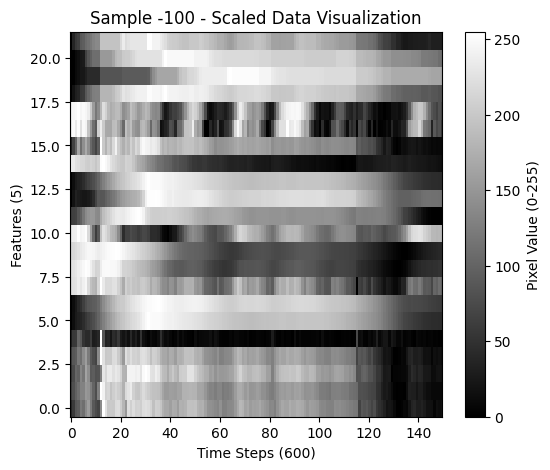

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def create_image_from_data(X_scaled: np.ndarray, sample_idx: int = 0) -> None:
    """
    Creates an image (600x5 pixels) from the scaled data (values between 0 and 1).
    The values are mapped from the range [0, 1] to [0, 255] for visual representation.

    Args:
        X_scaled: Scaled data array of shape (num_samples, 600, 5).
        sample_idx: Index of the sample to visualize.
    """
    # Get the selected sample (shape: 600, 5)
    sample_data = X_scaled[sample_idx, :, :]

    # Map the data from [0, 1] to [0, 255]
    sample_data_mapped = (sample_data * 255).astype(np.uint8)

    # Create the image (600x5)
    plt.figure(figsize=(6, 5))
    plt.imshow(sample_data_mapped.T, cmap='gray', aspect='auto', origin='lower', interpolation='none')

    # Set axis labels and title
    plt.title(f"Sample {sample_idx} - Scaled Data Visualization")
    plt.xlabel('Time Steps (600)')
    plt.ylabel('Features (5)')
    plt.colorbar(label='Pixel Value (0-255)')

    # Show the image
    plt.show()

# Example usage to visualize the first sample
create_image_from_data(X_test_scaled, sample_idx=-100)

# Prepare model

In [36]:

class Simple1DCNN(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.3):
        """
        An improved 1D CNN for time-series classification.

        Args:
            num_channels (int): Number of input channels (features). Defaults to 5 (e.g., open/high/low/close/volume).
            seq_len (int): Number of timesteps in each sample (e.g., 600).
            num_classes (int): Number of output classes (e.g., 3 for 'short','flat','long').
            dropout_p (float): Dropout probability for regularization. Defaults to 0.3.
        """
        super(Simple1DCNN, self).__init__()
        
        # -------------------------
        # Convolution Block 1
        # -------------------------
        self.conv1 = nn.Conv1d(
            in_channels=num_channels, 
            out_channels=32,
            kernel_size=5,         # Larger kernel for broader context
            stride=1, 
            padding=2              # "same" padding
        )
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # Halves sequence length: 600 -> 300

        # -------------------------
        # Convolution Block 2
        # -------------------------
        self.conv2 = nn.Conv1d(
            in_channels=32, 
            out_channels=64,
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 300 -> 150

        # -------------------------
        # Convolution Block 3
        # -------------------------
        self.conv3 = nn.Conv1d(
            in_channels=64, 
            out_channels=128,
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 150 -> 75

        # After 3 poolings, seq_len -> seq_len / 8
        # so final sequence length = 600 / 2 / 2 / 2 = 75
        # out channels = 128
        # flattened size = 128 * 75 = 9600
        self.dropout = nn.Dropout(p=dropout_p)

        # self.fc = nn.Linear(128 * (seq_len // 8), num_classes)

        # OPTIONAL: If you want to do global average pooling (instead of flattening),
        # you can comment out the above fc dimension logic and do:
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, channels=num_channels, seq_len)
        """
        # -------------------------
        # Block 1
        # -------------------------
        x = self.conv1(x)    # (batch, 32, seq_len=600)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)    # (batch, 32, 300)

        # -------------------------
        # Block 2
        # -------------------------
        x = self.conv2(x)    # (batch, 64, 300)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)    # (batch, 64, 150)

        # -------------------------
        # Block 3
        # -------------------------
        x = self.conv3(x)    # (batch, 128, 150)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)    # (batch, 128, 75)

        # -------------------------
        # Flatten or Global Pool
        # -------------------------
        # # 1) Flatten approach
        # x = x.view(x.size(0), -1)  # => (batch, 128 * 75)
        
        # # 2) Dropout for regularization
        # x = self.dropout(x)

        # # 3) Fully connected output
        # x = self.fc(x)  # => (batch, num_classes=3)

        # OPTIONAL (Global Pooling) approach:
        x = self.global_pool(x)  # => (batch, 128, 1)
        x = x.squeeze(-1)        # => (batch, 128)
        x = self.dropout(x)
        x = self.fc(x)

        return x

model = Simple1DCNN(num_channels=5, seq_len=600, num_classes=3)


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class Enlarged1DCNN(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        """
        An enlarged 1D CNN for time-series classification with enhanced capacity and regularization.
    
        Args:
            num_channels (int): Number of input channels (features). Defaults to 5 (e.g., open/high/low/close/volume).
            seq_len (int): Number of timesteps in each sample (e.g., 600).
            num_classes (int): Number of output classes (e.g., 3 for 'short','flat','long').
            dropout_p (float): Dropout probability for regularization. Defaults to 0.4.
        """
        super(Enlarged1DCNN, self).__init__()
        
        # -------------------------
        # Convolution Block 1
        # -------------------------
        self.conv1 = nn.Conv1d(
            in_channels=num_channels, 
            out_channels=64,           # Increased from 32 to 64
            kernel_size=7,             
            stride=1, 
            padding=3                  
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 600 -> 300
        self.dropout1 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Convolution Block 2
        # -------------------------
        self.conv2 = nn.Conv1d(
            in_channels=64, 
            out_channels=128,          # Increased from 64 to 128
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 300 -> 150
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Convolution Block 3
        # -------------------------
        self.conv3 = nn.Conv1d(
            in_channels=128, 
            out_channels=256,          # Increased from 128 to 256
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 150 -> 75
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Convolution Block 4 (Optional)
        # -------------------------
        self.conv4 = nn.Conv1d(
            in_channels=256, 
            out_channels=512,          # Additional layer
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(kernel_size=2)  # 75 -> 37 (rounded down)
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # -------------------------
        # Fully Connected Layers
        # -------------------------
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(512, 256)              # Increased size
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, seq_len)
        
        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        # -------------------------
        # Block 1
        # -------------------------
        x = self.conv1(x)       # (batch, 64, 600)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)       # (batch, 64, 300)
        x = self.dropout1(x)
    
        # -------------------------
        # Block 2
        # -------------------------
        x = self.conv2(x)       # (batch, 128, 300)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)       # (batch, 128, 150)
        x = self.dropout2(x)
    
        # -------------------------
        # Block 3
        # -------------------------
        x = self.conv3(x)       # (batch, 256, 150)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)       # (batch, 256, 75)
        x = self.dropout3(x)
    
        # -------------------------
        # Block 4 (Optional)
        # -------------------------
        x = self.conv4(x)       # (batch, 512, 75)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)       # (batch, 512, 37)
        x = self.dropout4(x)
    
        # -------------------------
        # Global Pooling and Fully Connected Layers
        # -------------------------
        x = self.global_pool(x) # (batch, 512, 1)
        x = x.squeeze(-1)       # (batch, 512)
        
        x = self.fc1(x)         # (batch, 256)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout_fc1(x)
        
        x = self.fc2(x)         # (batch, 128)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)         # (batch, num_classes)
    
        return x
    
model = Enlarged1DCNN(num_channels=5, seq_len=600, num_classes=3, dropout_p=0.6)



In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_p=0.4):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # If input and output channels differ, adjust the residual connection
        if in_channels != out_channels:
            self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()
        
    def forward(self, x):
        residual = self.residual(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResidualEnlarged1DCNN(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        super(ResidualEnlarged1DCNN, self).__init__()
        
        # Initial convolution
        self.conv_initial = nn.Conv1d(num_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn_initial = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 600 -> 300
        self.dropout_initial = nn.Dropout(p=dropout_p)
        
        # Residual Blocks
        self.res_block1 = ResidualBlock(64, 128, kernel_size=5, padding=2, dropout_p=dropout_p)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 300 -> 150
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        self.res_block2 = ResidualBlock(128, 256, kernel_size=3, padding=1, dropout_p=dropout_p)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 150 -> 75
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        self.res_block3 = ResidualBlock(256, 512, kernel_size=3, padding=1, dropout_p=dropout_p)
        self.pool4 = nn.MaxPool1d(kernel_size=2)  # 75 -> 37
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # Fully Connected Layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (batch, 512, 1)
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Initial convolution
        x = self.conv_initial(x)
        x = self.bn_initial(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.dropout_initial(x)
        
        # Residual Block 1
        x = self.res_block1(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Residual Block 2
        x = self.res_block2(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Residual Block 3
        x = self.res_block3(x)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Fully connected layers
        x = self.global_pool(x)  # (batch, 512, 1)
        x = x.squeeze(-1)        # (batch, 512)
        
        x = self.fc1(x)          # (batch, 256)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout_fc1(x)
        
        x = self.fc2(x)          # (batch, 128)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)          # (batch, num_classes)
        
        return x

# Initialize the residual enlarged model
model = ResidualEnlarged1DCNN(num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4)

# The rest of the training setup remains the same as before


In [39]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=1, 
        padding=1, 
        dropout_p=0.4
    ):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # If input and output channels differ or stride !=1, adjust the residual connection
        if in_channels != out_channels or stride != 1:
            self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.residual = nn.Identity()
        
    def forward(self, x):
        residual = self.residual(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResidualEnlarged1DCNN2(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        super(ResidualEnlarged1DCNN2, self).__init__()
        
        # Initial convolution with stride=2 for initial downsampling
        self.conv_initial = nn.Conv1d(num_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn_initial = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # Further downsampling
        self.dropout_initial = nn.Dropout(p=dropout_p)
        
        # Residual Blocks
        self.res_block1 = ResidualBlock(64, 128, kernel_size=5, stride=2, padding=2, dropout_p=dropout_p)
        self.dropout2 = nn.Dropout(p=dropout_p)
        
        self.res_block2 = ResidualBlock(128, 256, kernel_size=3, stride=2, padding=1, dropout_p=dropout_p)
        self.dropout3 = nn.Dropout(p=dropout_p)
        
        self.res_block3 = ResidualBlock(256, 512, kernel_size=3, stride=2, padding=1, dropout_p=dropout_p)
        self.dropout4 = nn.Dropout(p=dropout_p)
        
        # Fully Connected Layers with Global Avg and Max Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # (batch, 512, 1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)  # (batch, 512, 1)
        self.fc1 = nn.Linear(512 * 2, 256)  # Concatenated features
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Initial convolution
        x = self.conv_initial(x)          # Output shape: (batch, 64, seq_len/2)
        x = self.bn_initial(x)
        x = self.relu(x)
        x = self.pool1(x)                 # Output shape: (batch, 64, seq_len/4)
        x = self.dropout_initial(x)
        
        # Residual Block 1
        x = self.res_block1(x)            # Output shape: (batch, 128, seq_len/8)
        x = self.dropout2(x)
        
        # Residual Block 2
        x = self.res_block2(x)            # Output shape: (batch, 256, seq_len/16)
        x = self.dropout3(x)
        
        # Residual Block 3
        x = self.res_block3(x)            # Output shape: (batch, 512, seq_len/32)
        x = self.dropout4(x)
        
        # Global Pooling
        avg_pooled = self.global_avg_pool(x)  # Shape: (batch, 512, 1)
        max_pooled = self.global_max_pool(x)  # Shape: (batch, 512, 1)
        x = torch.cat((avg_pooled, max_pooled), dim=1)  # Shape: (batch, 1024, 1)
        x = x.squeeze(-1)                        # Shape: (batch, 1024)
        
        # Fully Connected Layers
        x = self.fc1(x)                          # Shape: (batch, 256)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout_fc1(x)
        
        x = self.fc2(x)                          # Shape: (batch, 128)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)                          # Shape: (batch, num_classes)
        
        return x
model = ResidualEnlarged1DCNN2(num_channels=5, seq_len=600, num_classes=3, dropout_p=0.6)


In [40]:
import torch
import torch.nn as nn

class FeatureSpecific1DCNN_MaxPooling(nn.Module):
    def __init__(self, num_channels=5, seq_len=600, num_classes=3, dropout_p=0.4):
        """
        Initializes the FeatureSpecific1DCNN model with 3 CNN layers per feature,
        per-branch max pooling, and a final MLP.

        Args:
            num_channels (int): Number of distinct features (default: 5).
            seq_len (int): Length of each time series sequence (default: 600).
            num_classes (int): Number of output classes (default: 3).
            dropout_p (float): Dropout probability (default: 0.4).
        """
        super(FeatureSpecific1DCNN_MaxPooling, self).__init__()
        self.num_channels = num_channels
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.dropout_p = dropout_p

        # Define the CNN blocks to reduce sequence length from 600 to 9 in 3 layers
        self.cnn_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=3),  # 600 -> 198
                nn.ReLU(),
                nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, stride=3), # 198 -> 64
                nn.ReLU(),
                nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, stride=7), # 64 -> 9
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(output_size=1)  # Global max pooling over the sequence length
            ) for _ in range(num_channels)
        ])

        # Each branch will now output (batch_size, 32, 1) after pooling
        # Flattened size per branch: 32
        self.flattened_size_per_branch = 32

        # Calculate the concatenated size from all branches
        self.concatenated_size = num_channels * self.flattened_size_per_branch  # e.g., 5 * 32 = 160

        # Define the final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(self.concatenated_size, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_channels, seq_len).

        Returns:
            torch.Tensor: Logits for each class.
        """
        # List to hold outputs from each CNN branch
        branch_outputs = []

        # Process each feature through its corresponding CNN branch
        for i in range(self.num_channels):
            # Extract the i-th feature: shape (batch_size, 1, seq_len)
            feature = x[:, i].unsqueeze(1)
            cnn_out = self.cnn_blocks[i](feature)  # Shape: (batch_size, 32, 1)
            cnn_out = cnn_out.view(cnn_out.size(0), -1)  # Flatten: (batch_size, 32)
            branch_outputs.append(cnn_out)

        # Concatenate all branch outputs: shape (batch_size, 160)
        concatenated = torch.cat(branch_outputs, dim=1)  # 5 branches * 32 = 160

        # Pass through the final MLP
        logits = self.final_mlp(concatenated)  # Shape: (batch_size, num_classes)

        return logits

# Instantiate the modified model
model = FeatureSpecific1DCNN_MaxPooling(num_channels=22, seq_len=600, num_classes=3, dropout_p=0.4)

# Print the model architecture to verify changes
print(model)


FeatureSpecific1DCNN_MaxPooling(
  (cnn_blocks): ModuleList(
    (0-21): 22 x Sequential(
      (0): Conv1d(1, 32, kernel_size=(7,), stride=(3,))
      (1): ReLU()
      (2): Conv1d(32, 32, kernel_size=(7,), stride=(3,))
      (3): ReLU()
      (4): Conv1d(32, 32, kernel_size=(7,), stride=(7,))
      (5): ReLU()
      (6): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (final_mlp): Sequential(
    (0): Linear(in_features=704, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [41]:
class TimeSeriesModel(nn.Module): 
    def __init__(self, num_channels=5, seq_len=150, num_classes=3, dropout_p=0.4):
        super(TimeSeriesModel, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv1d(
            in_channels=num_channels,      # 5 features: open, close, high, low, volume
            out_channels=64,               # Number of filters
            kernel_size=3,                 # Size of the convolutional kernel
            padding=1                      # To maintain the sequence length
        )
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.8)

        self.conv2 = nn.Conv1d(
            in_channels=64,      # 5 features: open, close, high, low, volume
            out_channels=16,               # Number of filters
            kernel_size=3,                 # Size of the convolutional kernel
            padding=1                      # To maintain the sequence length
        )
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        
        # Optionally, add more convolutional layers or pooling layers here
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(2400, 16)
        self.dropout3 = nn.Dropout(0.4)

        self.fc = nn.Linear(16, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)           # Apply convolution: (batch_size, 64, seq_len)
        x = self.dropout1(x)         # Apply dropout
        x = self.relu(x)  
        x = self.conv2(x)           # Apply convolution: (batch_size, 64, seq_len)
        x = self.dropout2(x)         # Apply dropout
        x = self.relu(x)          # Apply ReLU activation
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*seq_len)
        x = self.fc1(x)              # Fully connected layer to (batch_size, num_classes)
        x = self.dropout3(x)         # Apply dropout
        x = self.fc(x)              # Fully connected layer to (batch_size, num_classes)
        return x
    
model = TimeSeriesModel(num_channels=5, seq_len=150, num_classes=3, dropout_p=0.6)

# Print the model architecture to verify changes
print(model)

TimeSeriesModel(
  (conv1): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (dropout1): Dropout(p=0.8, inplace=False)
  (conv2): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=2400, out_features=16, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridCNN(nn.Module):
    def __init__(self, num_features=22, seq_len=150, num_classes=3, dropout_p=0.8):
        super(HybridCNN, self).__init__()
        
        # Shared Convolutional Layer
        self.shared_conv1 = nn.Conv1d(
            in_channels=num_features,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.shared_relu = nn.ReLU()
        self.shared_dropout = nn.Dropout1d(p=0.4)
        
        # Feature-Specific Convolutional Layers
        self.feature_cnns = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Dropout1d(p=0.6),
                nn.Conv1d(128, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Dropout1d(p=0.4)
            )
            for _ in range(num_features)
        ])
        
        # Additional Convolutional Layers to Replace fc1
        self.conv_reduce1 = nn.Conv1d(
            in_channels=32 * (1 + num_features),
            out_channels=128,
            kernel_size=3,
            stride=2,  # Reduce sequence length by half
            padding=1
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout1d(p=0.5)
        
        self.conv_reduce2 = nn.Conv1d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            stride=2,  # Further reduce sequence length
            padding=1
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout1d(p=0.5)
        
        # Global Average Pooling to get fixed-size vector
        self.global_pool = nn.AdaptiveAvgPool1d(3)  # Adjust as needed to reach desired size
        
        # Final Fully Connected Layer
        self.fc1 = nn.Linear(256 * 3, 256)  # 256 channels * 3 pooled features = 768
        self.dropout3 = nn.Dropout(p=0.5)

        self.fc_final = nn.Linear(256, num_classes)  # 256 channels * 3 pooled features = 768
        
    def forward(self, x):
        """
        Input shape: (batch_size, num_features=22, seq_len=150)
        """
        # Shared Convolution
        shared_out = self.shared_conv1(x)  # Shape: (batch_size, 32, 150)
        shared_out = self.shared_relu(shared_out)
        shared_out = self.shared_dropout(shared_out)
        
        # Feature-Specific Convolutions
        feature_outputs = []
        for i, cnn in enumerate(self.feature_cnns):
            feature = x[:, i:i+1, :]  # Shape: (batch_size, 1, 150)
            feature_out = cnn(feature)  # Shape: (batch_size, 32, 150)
            feature_outputs.append(feature_out)
        
        # Concatenate All Outputs
        all_features = torch.cat([shared_out] + feature_outputs, dim=1)  # Shape: (batch_size, 32*(1+22), 150) = (batch_size, 736, 150)
        
        # Replace Flattening with Additional Convolutions
        x = self.conv_reduce1(all_features)  # Shape: (batch_size, 128, 75)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.conv_reduce2(x)  # Shape: (batch_size, 256, 38) assuming stride=2
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Global Average Pooling
        x = self.global_pool(x)  # Shape: (batch_size, 256, 3)
        x = x.view(x.size(0), -1)  # Shape: (batch_size, 768)
        x = self.fc1(x)
        x = self.dropout3(x)
        # Final Classification Layer
        x = self.fc_final(x)  # Shape: (batch_size, num_classes)
        return x

# Instantiate the modified model
model = HybridCNN(num_features=22, seq_len=150, num_classes=3, dropout_p=0.8)

# Print the modified model architecture
print(model)


HybridCNN(
  (shared_conv1): Conv1d(22, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (shared_relu): ReLU()
  (shared_dropout): Dropout1d(p=0.4, inplace=False)
  (feature_cnns): ModuleList(
    (0-21): 22 x Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Dropout1d(p=0.6, inplace=False)
      (3): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU()
      (5): Dropout1d(p=0.4, inplace=False)
    )
  )
  (conv_reduce1): Conv1d(736, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (relu1): ReLU()
  (dropout1): Dropout1d(p=0.5, inplace=False)
  (conv_reduce2): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (relu2): ReLU()
  (dropout2): Dropout1d(p=0.5, inplace=False)
  (global_pool): AdaptiveAvgPool1d(output_size=3)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc_final): Linear(in_features=256, out_features=3, bia

# Load model

In [43]:
# # Reconstruct the model architecture
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = HybridCNN(num_features=22, seq_len=150, num_classes=3)

# # Load the saved state dictionary
# model.load_state_dict(torch.load(r"C:\GitCnn\CnnTrading\CnnTrans\HybridCNN_best_on_valid_state_dict.pth", map_location=device))

# # Move to device
# model.to(device)


# Train model

In [50]:
criterion = nn.CrossEntropyLoss()

In [51]:
import numpy as np

# Suppose X_train_scaled.shape = (19000, 600, 5)
# and y_train_encoded.shape = (19000,)
X_train_transposed = np.transpose(X_train_scaled, (0, 2, 1))  # (19000, 5, 600)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.from_numpy(X).float()  # shape: (num_samples, channels, seq_len)
        self.y = torch.from_numpy(y).long()   # shape: (num_samples,)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return (features, label) for sample 'idx'
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_transposed, y_train_encoded)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Suppose X_val_scaled.shape = (val_size, 600, 5)
# Suppose y_val_encoded.shape = (val_size,)

# 1) Transpose
X_val_transposed = np.transpose(np.concatenate((X_val_scaled, X_test_scaled), axis=0), (0, 2, 1))  # shape: (val_size, 5, 600)

# 2) Wrap in a Dataset
val_dataset = TimeSeriesDataset(X_val_transposed, np.concatenate((y_val_encoded, y_test_encoded), axis=0))

# 3) Create DataLoader (batch_size can match or differ from train)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assume train_loader and val_loader are predefined DataLoader instances
# Also assume that the model is defined and instantiated as `model`

# Initialize the device, model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
l2_lambda = 1e-4  # You can adjust this value based on your needs

# Initialize the optimizer with weight_decay for L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=l2_lambda)

# Initialize the learning rate scheduler
# Here, ReduceLROnPlateau reduces the LR by a factor of 0.1 if validation loss doesn't improve for 5 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)

# Set the desired validation loss threshold
validation_threshold = 0.25

epoch_loss = 1
epoch = 0

while True:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch += 1
    
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    
    # Validation every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # To collect predictions and true labels for further metrics
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)              # shape: (batch_size, num_classes)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)

                # Predictions
                _, predicted = torch.max(outputs, 1)  # shape: (batch_size,)
                
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
                
                # Store predictions & labels for confusion matrix, etc.
                all_preds.append(predicted.cpu().numpy())
                all_labels.append(y_batch.cpu().numpy())

        # Convert lists of arrays into a single 1D array
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        val_loss /= total
        val_acc = correct / total

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # --------------------------------------------------------------------------
        # Additional Metrics
        # --------------------------------------------------------------------------

        # 1) Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print("Confusion Matrix:")
        print(cm)

        # 2) Classification Report
        #    If you have 3 classes: 0="short", 1="flat", 2="long" (example)
        target_names = ["short", "flat", "long"]  # adjust if needed
        report = classification_report(all_labels, all_preds, target_names=target_names)
        print("Classification Report:")
        print(report)
        
        # Step the scheduler with the validation loss
        scheduler.step(val_loss)
        print(f"Learning Rate after scheduler step: {optimizer.param_groups[0]['lr']:.6f}")
        
        # If the validation loss is acceptable, stop training
        if val_loss <= validation_threshold or optimizer.param_groups[0]['lr'] < 1e-8:
            print(f"Validation loss has reached the threshold of {validation_threshold:.4f}, stopping training.")
            break


c:\GitCnn\CnnTrading\CnnTrans\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 1.1021, Acc: 0.3238
Epoch 2, Loss: 1.0996, Acc: 0.3288
Epoch 3, Loss: 1.0996, Acc: 0.3375
Epoch 4, Loss: 1.0994, Acc: 0.3317


: 

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Final model saved to {MODEL_PATH}")

# Validate model

In [ ]:
target_names = ["short", "flat", "long"]  # Adjust based on your class names
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

model.eval()
val_loss = 0.0
correct = 0
total = 0

# To collect predictions and true labels for further metrics
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)              # shape: (batch_size, num_classes)
        loss = criterion(outputs, y_batch)

        val_loss += loss.item() * X_batch.size(0)

        # Predictions
        _, predicted = torch.max(outputs, 1)  # shape: (batch_size,)
        
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        
        # Store predictions & labels for confusion matrix, etc.
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Convert lists of arrays into a single 1D array
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

val_loss /= total
val_acc = correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

# --------------------------------------------------------------------------
# Additional Metrics
# --------------------------------------------------------------------------

target_names = ["short", "flat", "long"]  # adjust if needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names) 
disp.plot() 
# And show it: 
plt.show()
# 2) Classification Report
#    If you have 3 classes: 0="short", 1="flat", 2="long" (example)
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


# Test model

In [52]:
# Suppose X_test_scaled.shape = (test_size, 600, 5)
# Suppose y_test_encoded.shape = (test_size,)

# 1) Transpose
X_test_transposed = np.transpose(X_test_scaled, (0, 2, 1))  # shape: (test_size, 5, 600)

# 2) Wrap in a Dataset
test_dataset = TimeSeriesDataset(X_test_transposed, y_test_encoded)

# 3) Create DataLoader (batch_size can match or differ from train)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
val_loss = 0.0
correct = 0
total = 0

# To collect predictions and true labels for further metrics
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)              # shape: (batch_size, num_classes)
        loss = criterion(outputs, y_batch)

        val_loss += loss.item() * X_batch.size(0)

        # Predictions
        _, predicted = torch.max(outputs, 1)  # shape: (batch_size,)
        
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        
        # Store predictions & labels for confusion matrix, etc.
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Convert lists of arrays into a single 1D array
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

val_loss /= total
val_acc = correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

# --------------------------------------------------------------------------
# Additional Metrics
# --------------------------------------------------------------------------

# 1) Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 2) Classification Report
#    If you have 3 classes: 0="short", 1="flat", 2="long" (example)
target_names = ["short", "flat", "long"]  # adjust if needed
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


In [42]:
# Let's do inference on a single sample from X_test
predicted_labels = []
model.eval()

for X_single in X_test_slice:
    X_single_scaled = MinMaxScaler().fit_transform(X_single)  # shape (600,5)
    X_single_scaled = np.expand_dims(X_single_scaled, axis=0)  # => (1,600,5)
    X_single_transposed = np.transpose(X_single_scaled, (0, 2, 1))  # => (1,5,600)
    X_single_tensor = torch.from_numpy(X_single_transposed).float().to(device)
    with torch.no_grad():
        output = model(X_single_tensor)   # => shape (1,3)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()  # 0,1,2

    label_map = {0:"short",1:"flat",2:"long"}
    predicted_labels.append(label_map[predicted_label])

In [ ]:
kek = labels_test_slice == predicted_labels
unique, counts = np.unique(kek, return_counts=True)

dict(zip(unique, counts))

In [ ]:
compute_trading_statistics(X_test_slice, y_test_slice, labels_test_slice,  500, 100)
# compute_profit(X, y, predicted_labels)


In [ ]:
compute_trading_statistics(X_test_slice, y_test_slice, predicted_labels, 500, 100)
# compute_profit(X, y, labels)


In [127]:
def plot_input_output_combined_with_label(
    input_sequence: np.ndarray,
    output_sequence: np.ndarray,
    label: str,
    title: str = "Input + Output Window on One Chart"
):
    """
    Plots both input and output windows on a single candlestick chart.
    The output window candles will be overlaid in a color depending on 'label':
      - long -> green
      - short -> red
      - flat -> blue

    Args:
        input_sequence (np.ndarray): OHLCV data for the input window (shape: [N, >=5])
        output_sequence (np.ndarray): OHLCV data for the output window (shape: [M, >=5])
        label (str): The trading signal for the output window ('long', 'short', 'flat').
        title (str): The title of the chart.
    """

    # Use only the first 5 columns (OHLCV)
    input_sequence = input_sequence[:, :5]
    output_sequence = output_sequence[:, :5]

    # Generate a continuous datetime index for plotting
    input_dates = pd.date_range(start="2023-01-01", periods=len(input_sequence), freq="min")
    output_dates = pd.date_range(start=input_dates[-1] + pd.Timedelta(minutes=1), periods=len(output_sequence), freq="min")

    # Convert to DataFrames with appropriate columns
    input_df = pd.DataFrame(input_sequence, columns=["Open", "High", "Low", "Close", "Volume"], index=input_dates)
    output_df = pd.DataFrame(output_sequence, columns=["Open", "High", "Low", "Close", "Volume"], index=output_dates)

    # Concatenate input and output DataFrames
    combined_df = pd.concat([input_df, output_df])

    # Create a market colors style for the input sequence (standard green/red)
    input_market_colors = mpf.make_marketcolors(
        up='green', down='red', edge='inherit', wick='inherit', volume='inherit'
    )
    input_style = mpf.make_mpf_style(marketcolors=input_market_colors)

    # Plot the combined data with the input sequence style
    fig, axes = mpf.plot(
        combined_df,
        type='candle',
        style=input_style,
        volume=True,
        mav=(20, 50),
        returnfig=True,
        title=title,
        figsize=(12, 8),
        show_nontrading=True
    )
    ax_main = axes[0]  # main price axis

    # Determine the output candlestick color based on label
    if label == 'long':
        color_up = 'green'
        color_down = 'green'
    elif label == 'short':
        color_up = 'red'
        color_down = 'red'
    else:  # 'flat'
        color_up = 'blue'
        color_down = 'blue'

    # Create a market colors style for the output sequence
    output_market_colors = mpf.make_marketcolors(
        up=color_up,
        down=color_down,
        edge='inherit',
        wick='inherit',
        volume='inherit'
    )
    output_style = mpf.make_mpf_style(marketcolors=output_market_colors)

    # Overlay the output sequence with its own style
    mpf.plot(
        output_df,
        type='candle',
        ax=ax_main,
        style=output_style,
        volume=False,
        mav=(20, 50),
        show_nontrading=True
    )


In [ ]:
for idx in random.sample(range(len(X_test_slice)), 100):
    sample_idx = X_test_slice[idx]
    print("expected/predicted: ", labels_test_slice[idx], predicted_labels[idx], "correct: ", "model" if \
        compute_profit(np.expand_dims(X_test_slice[idx], axis=0), np.expand_dims(y_test_slice[idx], axis=0), np.expand_dims(predicted_labels[idx], axis=0))\
        >= \
        compute_profit(np.expand_dims(X_test_slice[idx], axis=0), np.expand_dims(y_test_slice[idx], axis=0), np.expand_dims(labels_test_slice[idx], axis=0))\
        else "algo"
            )
    # plot_input_output_combined_with_label(
    #     X_test_slice[idx],
    #     y_test_slice[idx],
    #     label=predicted_labels[idx],
    #     title="Input+Output, Colored by Label"
    # )


# Benchmark

In [338]:
MODEL_PATH = 'simple1dcnn_state_dict.pth'
required_columns = ['date', 'open', 'high', 'low', 'close', 'volume']
# file_path = r"C:\GitCnn\CnnTrading\CnnTrans\merged_output.csv"
file_path = r"DataFromBinance.csv"
input_window = 150
output_window = 15
np.set_printoptions(formatter={'float_kind': lambda x: f'{x:.2f}'})
random.seed(42)
np.random.seed(42)

In [339]:
# 1) Read & sort in descending order
df = read_and_sort_csv(file_path, required_columns)[-30000:]

# Assuming 'df' is your DataFrame with 'open', 'high', 'low', 'close', 'volume'

# Moving Averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

# RSI
df['RSI_14'] = momentum.RSIIndicator(close=df['close'], window=14).rsi()

# MACD
macd = trend.MACD(close=df['close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# Bollinger Bands
bollinger = volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# ATR
df['ATR_14'] = volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()

# OBV
df['OBV'] = volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()

# Stochastic Oscillator
stochastic = momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
df['Stochastic_%K'] = stochastic.stoch()
df['Stochastic_%D'] = stochastic.stoch_signal()

# Ichimoku Cloud
ichimoku = trend.IchimokuIndicator(high=df['high'], low=df['low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()
df['Ichimoku_Base_Line'] = ichimoku.ichimoku_base_line()
df['Ichimoku_Conversion_Line'] = ichimoku.ichimoku_conversion_line()

# Handle missing values
df.dropna(inplace=True)  # or df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame


In [ ]:
df.describe()

In [ ]:
df

In [342]:
X, y = create_sequences(df, input_window=input_window, output_window=output_window, step=1)

In [ ]:
len(X)

In [ ]:
labels = compute_labels_simple(X, y, threshold = 0.15)
print(f"\nCreated {X.shape[0]} input-output sequences.")
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

In [ ]:
# Reconstruct the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridCNN(num_features=22, seq_len=150, num_classes=3)

# Load the saved state dictionary
model.load_state_dict(torch.load(r"C:\GitCnn\CnnTraading\CnnTrans\HybridCNN_best_on_valid_state_dict.pth", map_location=device))

# Move to device
model.to(device)


In [346]:
# Let's do inference on a single sample from X_test
predicted_labels = []
model.eval()

for X_single in X:
    X_single_scaled = MinMaxScaler().fit_transform(X_single)  # shape (600,5)
    X_single_scaled = np.expand_dims(X_single_scaled, axis=0)  # => (1,600,5)
    X_single_transposed = np.transpose(X_single_scaled, (0, 2, 1))  # => (1,5,600)
    X_single_tensor = torch.from_numpy(X_single_transposed).float().to(device)
    with torch.no_grad():
        output = model(X_single_tensor)   # => shape (1,3)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()  # 0,1,2

    label_map = {0:"short",1:"flat",2:"long"}
    predicted_labels.append(label_map[predicted_label])

In [ ]:
kek = labels == predicted_labels
unique, counts = np.unique(kek, return_counts=True)

dict(zip(unique, counts))

In [348]:
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # Import Pearson correlation function

@dataclass
class TradingStatisticDTO:
    initial_capital: float
    final_capital: float
    total_profit: float
    average_profit: float
    return_on_investment: float
    num_trades: int
    long_trades: int
    short_trades: int
    flat_trades: int
    position_size_per_trade: float  # Position size in dollars
    
    # Additional Metrics
    win_trades: int
    loss_trades: int
    win_rate: float
    loss_rate: float
    average_win: float
    average_loss: float
    profit_factor: float
    max_drawdown: float
    max_consecutive_wins: int
    max_consecutive_losses: int
    max_win: float        # New Metric: Maximum single trade profit
    max_loss: float       # New Metric: Maximum single trade loss
    
    # New Attribute: Capital History
    capital_history: list = field(default_factory=list, repr=False)
    
    def to_dataframe(self) -> pd.DataFrame:
        """
        Converts the trading statistics into a Pandas DataFrame.

        Returns:
            pd.DataFrame: DataFrame containing all trading statistics.
        """
        data = {
            'Initial Capital': [self.initial_capital],
            'Final Capital': [self.final_capital],
            'Total Profit': [self.total_profit],
            'Average Profit': [self.average_profit],
            'Return on Investment (ROI)': [self.return_on_investment],
            'Number of Trades': [self.num_trades],
            'Long Trades': [self.long_trades],
            'Short Trades': [self.short_trades],
            'Flat Trades': [self.flat_trades],
            'Position Size per Trade': [self.position_size_per_trade],
            'Winning Trades': [self.win_trades],
            'Losing Trades': [self.loss_trades],
            'Win Rate (%)': [self.win_rate],
            'Loss Rate (%)': [self.loss_rate],
            'Average Win': [self.average_win],
            'Average Loss': [self.average_loss],
            'Profit Factor': [self.profit_factor],
            'Maximum Drawdown': [self.max_drawdown],
            'Max Consecutive Wins': [self.max_consecutive_wins],
            'Max Consecutive Losses': [self.max_consecutive_losses],
            'Max Win': [self.max_win],
            'Max Loss': [self.max_loss],
        }
        df = pd.DataFrame(data)
        return df

    def compare(self, other: 'TradingStatisticDTO', this_name: str, other_name: str) -> pd.DataFrame:
        """
        Compares this TradingStatisticDTO with another instance and returns a DataFrame of differences.

        Args:
            other (TradingStatisticDTO): The other trading statistics to compare against.
            this_name (str): Name/Identifier for the current instance.
            other_name (str): Name/Identifier for the other instance.

        Returns:
            pd.DataFrame: DataFrame containing comparison of metrics between the two instances.
        """
        metrics = {
            'Final Capital': ('final_capital', 'higher is better'),
            'Total Profit': ('total_profit', 'higher is better'),
            'Average Profit': ('average_profit', 'higher is better'),
            'Return on Investment (ROI)': ('return_on_investment', 'higher is better'),
            'Number of Trades': ('num_trades', 'lower is better'),
            'Long Trades': ('long_trades', 'no specific preference'),
            'Short Trades': ('short_trades', 'no specific preference'),
            'Win Trades': ('win_trades', 'higher is better'),
            'Loss Trades': ('loss_trades', 'lower is better'),
            'Win Rate (%)': ('win_rate', 'higher is better'),
            'Loss Rate (%)': ('loss_rate', 'lower is better'),
            'Average Win': ('average_win', 'higher is better'),
            'Average Loss': ('average_loss', 'lower is better'),
            'Profit Factor': ('profit_factor', 'higher is better'),
            'Maximum Drawdown': ('max_drawdown', 'lower is better'),
            'Max Consecutive Wins': ('max_consecutive_wins', 'higher is better'),
            'Max Consecutive Losses': ('max_consecutive_losses', 'lower is better'),
            'Max Win': ('max_win', 'higher is better'),
            'Max Loss': ('max_loss', 'lower is better'),
        }

        comparison_results = []

        for metric_name, (attribute, preference) in metrics.items():
            self_value = getattr(self, attribute)
            other_value = getattr(other, attribute)
            difference = self_value - other_value

            if preference == 'higher is better':
                if difference > 0:
                    status = 'Improved'
                elif difference < 0:
                    status = 'Declined'
                else:
                    status = 'Same'
            elif preference == 'lower is better':
                if difference < 0:
                    status = 'Improved'
                elif difference > 0:
                    status = 'Declined'
                else:
                    status = 'Same'
            else:
                # For metrics where no specific preference is set
                if difference > 0:
                    status = 'Increased'
                elif difference < 0:
                    status = 'Decreased'
                else:
                    status = 'Same'

            # Format the difference
            if isinstance(self_value, float):
                if 'Rate' in metric_name or 'Drawdown' in metric_name:
                    # Format rates and drawdowns with appropriate units
                    if 'Rate' in metric_name:
                        diff_formatted = f"{difference:+.2f}%"
                    elif 'Drawdown' in metric_name:
                        diff_formatted = f"${difference:+,.2f}"
                    else:
                        diff_formatted = f"${difference:+,.2f}"
                else:
                    diff_formatted = f"${difference:+,.2f}"
            else:
                diff_formatted = f"{difference:+}"

            # Prepare display values
            if isinstance(other_value, float):
                if 'Rate' in metric_name:
                    other_display = f"{other_value:.2f}%"
                elif 'Drawdown' in metric_name:
                    other_display = f"${other_value:,.2f}"
                else:
                    other_display = f"${other_value:,.2f}"
            else:
                other_display = f"{other_value}"
            
            if isinstance(self_value, float):
                if 'Rate' in metric_name:
                    self_display = f"{self_value:.2f}%"
                elif 'Drawdown' in metric_name:
                    self_display = f"${self_value:,.2f}"
                else:
                    self_display = f"${self_value:,.2f}"
            else:
                self_display = f"{self_value}"

            comparison_results.append({
                'Metric': metric_name,
                other_name: other_display,
                this_name: self_display,
                'Difference': diff_formatted,
                'Status': status
            })

        comparison_df = pd.DataFrame(comparison_results)
        return comparison_df

    def plot_capital_history(self, title: str = "Capital Over Time"):
        """
        Plots the capital history over time.

        Args:
            title (str, optional): The title of the plot. Defaults to "Capital Over Time".
        """
        if not self.capital_history:
            print("No capital history to plot.")
            return
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.capital_history, label='Capital', color='blue')
        plt.title(title)
        plt.xlabel('Trade Number')
        plt.ylabel('Capital ($)')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def correlation_with_linear_trend(self) -> float:
        """
        Calculates the Pearson correlation coefficient between the actual capital history
        and an ideal linear trend from initial to final capital.

        Returns:
            float: Pearson correlation coefficient. Returns np.nan if calculation is not possible.
        """
        if not self.capital_history:
            print("Capital history is empty.")
            return np.nan
        if len(self.capital_history) < 2:
            print("Not enough data points to calculate correlation.")
            return np.nan
        
        n = len(self.capital_history)
        linear_trend = np.linspace(self.initial_capital, self.final_capital, n)
        
        # Calculate Pearson correlation
        corr_coeff, _ = pearsonr(self.capital_history, linear_trend)
        return corr_coeff


In [369]:
def compute_trading_statistics(
    X_benchmark: np.ndarray,
    labels: list,
    initial_capital: float,
    position_size_dollars: float = 1000.0,  # Fixed position size per trade in dollars
    close_idx: int = 3,
    high_idx: int = 1,  # Index for High price
    low_idx: int = 2,   # Index for Low price
    commission_rate: float = 0.0005,
    tp_percent: float = 0.01,  # 1% Take Profit
    sl_percent: float = 0.005  # 0.5% Stop Loss
) -> TradingStatisticDTO:
    """
    Computes trading statistics based on initial capital, fixed dollar position size, and trade profits.
    Positions are closed based on fixed Take Profit (TP) and Stop Loss (SL) percentages using High and Low prices.
    Incorporates dynamic adjustment of SL and TP based on incoming labels.
    
    Args:
        X_benchmark (np.ndarray): Input prices, shape (num_time_steps, num_features).
        labels (list or np.ndarray): Trade labels for each time step ("long", "short", "flat").
        initial_capital (float): The starting capital for trading.
        position_size_dollars (float, optional): Fixed dollar amount per trade. Defaults to 1000.0.
        close_idx (int, optional): Index of the closing price in the feature array. Defaults to 3.
        high_idx (int, optional): Index of the high price in the feature array. Defaults to 2.
        low_idx (int, optional): Index of the low price in the feature array. Defaults to 1.
        commission_rate (float, optional): Commission rate per trade (as a decimal). Defaults to 0.0005.
        tp_percent (float, optional): Take Profit percentage (e.g., 0.01 for 1%). Defaults to 0.01.
        sl_percent (float, optional): Stop Loss percentage (e.g., 0.005 for 0.5%). Defaults to 0.005.

    Returns:
        TradingStatisticDTO: An object containing various trading statistics.
    """
    # Parameter Validation (unchanged)
    if initial_capital <= 0:
        raise ValueError("Initial capital must be greater than zero.")
    if position_size_dollars <= 0:
        raise ValueError("Position size must be greater than zero.")
    if not isinstance(labels, (list, np.ndarray)):
        raise TypeError("Labels must be a list or numpy array.")
    if X_benchmark.shape[0] != len(labels):
        raise ValueError("Number of time steps in X_benchmark must match the number of labels.")

    num_time_steps = X_benchmark.shape[0]
    total_profit = 0.0
    long_trades = 0
    short_trades = 0
    flat_trades = 0
    num_trades = 0

    # Additional Metrics Variables
    win_trades = 0
    loss_trades = 0
    total_win = 0.0
    total_loss = 0.0
    trade_profits = []  # List to store individual trade profits for profit factor
    current_capital = initial_capital
    max_capital = initial_capital
    max_drawdown = 0.0
    consecutive_wins = 0
    max_consecutive_wins = 0
    consecutive_losses = 0
    max_consecutive_losses = 0
    max_win = float('-inf')  # Initialize to negative infinity
    max_loss = float('inf')  # Initialize to infinity

    # To track consecutive wins/losses
    last_trade_result = None  # 'win' or 'loss'

    current_position = 'flat'  # Possible values: 'flat', 'long', 'short'
    entry_price = 0.0
    tp_level = 0.0
    sl_level = 0.0

    # Initialize capital history
    capital_history = [initial_capital]

    for i in range(num_time_steps):
        label = labels[i]
        close_price = X_benchmark[i, close_idx]
        high_price = X_benchmark[i, high_idx]
        low_price = X_benchmark[i, low_idx]

        if current_position == 'flat':
            # Only consider opening a new position if flat
            if label == "long":
                # Open a long position at Close price
                current_position = "long"
                entry_price = close_price
                long_trades += 1
                num_trades += 1
                # Calculate TP and SL levels based on entry price
                tp_level = entry_price * (1 + tp_percent)
                sl_level = entry_price * (1 - sl_percent)
                # Commission on entry
                # position_size_dollars = current_capital*0.3  # Adjusted position size as per original code
                commission = commission_rate * position_size_dollars
                total_profit -= commission
                current_capital -= commission
            elif label == "short":
                # Open a short position at Close price
                current_position = "short"
                entry_price = close_price
                short_trades += 1
                num_trades += 1
                # Calculate TP and SL levels based on entry price
                tp_level = entry_price * (1 - tp_percent)
                sl_level = entry_price * (1 + sl_percent)
                # Commission on entry
                # position_size_dollars = current_capital*0.3  # Adjusted position size as per original code
                commission = commission_rate * position_size_dollars
                total_profit -= commission
                current_capital -= commission
            else:
                flat_trades += 1
            # Record capital after deciding on position
            capital_history.append(current_capital)
        else:
            # Currently in a position; check for dynamic adjustments and TP/SL hits
            trade_closed = False
            profit = 0.0

            # **Dynamic Stop-Loss Adjustment on Reversal Labels**
            if (label == "long" and current_position == "short") or (label == "short" and current_position == "long"):
                if label == "long" and current_position == "short":
                    # Potential reversal from short to long
                    # Calculate new SL for the short position based on current price
                    new_sl_level = close_price * (1 + sl_percent)
                    # For short positions, SL is above the entry price
                    # Only update SL if new SL is closer to current price than existing SL
                    if new_sl_level < sl_level:
                        sl_level = new_sl_level  # Update to closer SL
                elif label == "short" and current_position == "long":
                    # Potential reversal from long to short
                    # Calculate new SL for the long position based on current price
                    new_sl_level = close_price * (1 - sl_percent)
                    # For long positions, SL is below the entry price
                    # Only update SL if new SL is closer to current price than existing SL
                    if new_sl_level > sl_level:
                        sl_level = new_sl_level  # Update to closer SL

            # **Dynamic Take-Profit Adjustment on Same Labels**
            if label == current_position:
                if current_position == "long":
                    # Calculate new TP based on current price
                    new_tp_level = close_price * (1 + tp_percent)
                    # Update TP only if new TP is further from current price than existing TP
                    if new_tp_level > tp_level:
                        tp_level = new_tp_level
                elif current_position == "short":
                    # Calculate new TP based on current price
                    new_tp_level = close_price * (1 - tp_percent)
                    # Update TP only if new TP is further from current price than existing TP
                    if new_tp_level < tp_level:
                        tp_level = new_tp_level

            # **Check for TP or SL Hits**
            if current_position == "long":
                # For long positions, TP is higher than entry, SL is lower
                # Check TP first using High price
                if high_price >= tp_level:
                    # Take Profit at TP level
                    exit_price = tp_level
                    profit = (exit_price - entry_price) * (position_size_dollars / entry_price) - (commission_rate * position_size_dollars)
                    trade_closed = True
                # If TP not hit, check SL using Low price
                elif low_price <= sl_level:
                    # Stop Loss at SL level
                    exit_price = sl_level
                    profit = (exit_price - entry_price) * (position_size_dollars / entry_price) - (commission_rate * position_size_dollars)
                    trade_closed = True
            elif current_position == "short":
                # For short positions, TP is lower than entry, SL is higher
                # Check TP first using Low price
                if low_price <= tp_level:
                    # Take Profit at TP level
                    exit_price = tp_level
                    profit = (entry_price - exit_price) * (position_size_dollars / entry_price) - (commission_rate * position_size_dollars)
                    trade_closed = True
                # If TP not hit, check SL using High price
                elif high_price >= sl_level:
                    # Stop Loss at SL level
                    exit_price = sl_level
                    profit = (entry_price - exit_price) * (position_size_dollars / entry_price) - (commission_rate * position_size_dollars)
                    trade_closed = True

            if trade_closed:
                total_profit += profit
                current_capital += profit
                trade_profits.append(profit)

                # Update max win and max loss
                if profit > max_win:
                    max_win = profit
                if profit < max_loss:
                    max_loss = profit

                # Update drawdown
                if current_capital > max_capital:
                    max_capital = current_capital
                drawdown = max_capital - current_capital
                if drawdown > max_drawdown:
                    max_drawdown = drawdown

                # Update win/loss statistics
                if profit > 0:
                    win_trades += 1
                    total_win += profit
                    if last_trade_result == 'win':
                        consecutive_wins += 1
                    else:
                        consecutive_wins = 1
                        consecutive_losses = 0
                    last_trade_result = 'win'
                    if consecutive_wins > max_consecutive_wins:
                        max_consecutive_wins = consecutive_wins
                elif profit < 0:
                    loss_trades += 1
                    total_loss += abs(profit)
                    if last_trade_result == 'loss':
                        consecutive_losses += 1
                    else:
                        consecutive_losses = 1
                        consecutive_wins = 0
                    last_trade_result = 'loss'
                    if consecutive_losses > max_consecutive_losses:
                        max_consecutive_losses = consecutive_losses
                else:
                    # Break-even trade; do not count as win or loss
                    consecutive_wins = 0
                    consecutive_losses = 0
                    last_trade_result = None

                # Reset position
                current_position = "flat"

                # Record capital after closing the trade
                capital_history.append(current_capital)
            else:
                # Position remains open; record current capital without changes
                capital_history.append(current_capital)

    # After iterating through all time steps, check if a position is still open and close it
    if current_position != "flat":
        exit_price = X_benchmark[-1, close_idx]
        if current_position == "long":
            profit = (exit_price - entry_price) * (position_size_dollars / entry_price) - (commission_rate * position_size_dollars)
        elif current_position == "short":
            profit = (entry_price - exit_price) * (position_size_dollars / entry_price) - (commission_rate * position_size_dollars)
        total_profit += profit
        current_capital += profit
        trade_profits.append(profit)

        # Update max win and max loss
        if profit > max_win:
            max_win = profit
        if profit < max_loss:
            max_loss = profit

        # Update drawdown
        if current_capital > max_capital:
            max_capital = current_capital
        drawdown = max_capital - current_capital
        if drawdown > max_drawdown:
            max_drawdown = drawdown

        # Update win/loss statistics
        if profit > 0:
            win_trades += 1
            total_win += profit
            if last_trade_result == 'win':
                consecutive_wins += 1
            else:
                consecutive_wins = 1
                consecutive_losses = 0
            last_trade_result = 'win'
            if consecutive_wins > max_consecutive_wins:
                max_consecutive_wins = consecutive_wins
        elif profit < 0:
            loss_trades += 1
            total_loss += abs(profit)
            if last_trade_result == 'loss':
                consecutive_losses += 1
            else:
                consecutive_losses = 1
                consecutive_wins = 0
            last_trade_result = 'loss'
            if consecutive_losses > max_consecutive_losses:
                max_consecutive_losses = consecutive_losses
        else:
            # Break-even trade; do not count as win or loss
            consecutive_wins = 0
            consecutive_losses = 0
            last_trade_result = None

        # Increment trade count for closing trade
        if current_position == "long":
            long_trades += 1
        elif current_position == "short":
            short_trades += 1
        num_trades += 1  # Closing trade

        # Record capital after closing the final trade
        capital_history.append(current_capital)

    # Calculate average profit
    average_profit = total_profit / num_trades if num_trades > 0 else 0.0

    # Calculate ROI
    return_on_investment = (total_profit / initial_capital) * 100 if initial_capital != 0 else 0.0

    # Calculate Win/Loss Rates
    win_rate = (win_trades / num_trades) * 100 if num_trades > 0 else 0.0
    loss_rate = (loss_trades / num_trades) * 100 if num_trades > 0 else 0.0

    # Calculate Average Win and Average Loss
    average_win = (total_win / win_trades) if win_trades > 0 else 0.0
    average_loss = (total_loss / loss_trades) if loss_trades > 0 else 0.0

    # Calculate Profit Factor
    profit_factor = (total_win / total_loss) if total_loss > 0 else float('inf')

    # Prepare the TradingStatisticDTO with all metrics
    trading_stats = TradingStatisticDTO(
        initial_capital=initial_capital,
        final_capital=current_capital,
        total_profit=total_profit,
        average_profit=average_profit,
        return_on_investment=return_on_investment,
        num_trades=num_trades,
        long_trades=long_trades,
        short_trades=short_trades,
        flat_trades=flat_trades,
        position_size_per_trade=position_size_dollars,
        win_trades=win_trades,
        loss_trades=loss_trades,
        win_rate=win_rate,
        loss_rate=loss_rate,
        average_win=average_win,
        average_loss=average_loss,
        profit_factor=profit_factor,
        max_drawdown=max_drawdown,
        max_consecutive_wins=max_consecutive_wins,
        max_consecutive_losses=max_consecutive_losses,
        max_win=max_win if max_win != float('-inf') else 0.0,    # Handle case with no wins
        max_loss=max_loss if max_loss != float('inf') else 0.0,  # Handle case with no losses
    )

    # Assign the capital history
    trading_stats.capital_history = capital_history

    return trading_stats


In [384]:
class TradingStatisticsCalculator:
    def __init__(
        self,
        initial_capital: float,
        position_size_dollars: float = 1000.0,  # Fixed position size per trade in dollars
        close_idx: int = 3,
        high_idx: int = 1,  # Index for High price
        low_idx: int = 2,   # Index for Low price
        commission_rate: float = 0.0005,
        tp_percent: float = 0.01,  # 1% Take Profit
        sl_percent: float = 0.005  # 0.5% Stop Loss
    ):
        """
        Initializes the TradingStatisticsCalculator with the given parameters.

        Args:
            initial_capital (float): The starting capital for trading.
            position_size_dollars (float, optional): Fixed dollar amount per trade. Defaults to 1000.0.
            close_idx (int, optional): Index of the closing price in the feature array. Defaults to 3.
            high_idx (int, optional): Index of the high price in the feature array. Defaults to 1.
            low_idx (int, optional): Index of the low price in the feature array. Defaults to 2.
            commission_rate (float, optional): Commission rate per trade (as a decimal). Defaults to 0.0005.
            tp_percent (float, optional): Take Profit percentage (e.g., 0.01 for 1%). Defaults to 0.01.
            sl_percent (float, optional): Stop Loss percentage (e.g., 0.005 for 0.5%). Defaults to 0.005.
        """
        # Parameter Validation
        if initial_capital <= 0:
            raise ValueError("Initial capital must be greater than zero.")
        if position_size_dollars <= 0:
            raise ValueError("Position size must be greater than zero.")
        
        self.position_size_dollars = position_size_dollars
        self.initial_capital = initial_capital
        self.close_idx = close_idx
        self.high_idx = high_idx
        self.low_idx = low_idx
        self.commission_rate = commission_rate
        self.tp_percent = tp_percent
        self.sl_percent = sl_percent
        self.total_profit = 0.0
        self.long_trades = 0
        self.short_trades = 0
        self.flat_trades = 0
        self.num_trades = 0

        # Additional Metrics Variables
        self.win_trades = 0
        self.loss_trades = 0
        self.total_win = 0.0
        self.total_loss = 0.0
        self.trade_profits = []  # List to store individual trade profits for profit factor
        self.current_capital = initial_capital
        self.max_capital = initial_capital
        self.max_drawdown = 0.0
        self.consecutive_wins = 0
        self.max_consecutive_wins = 0
        self.consecutive_losses = 0
        self.max_consecutive_losses = 0
        self.max_win = float('-inf')  # Initialize to negative infinity
        self.max_loss = float('inf')  # Initialize to infinity

        # To track consecutive wins/losses
        self.last_trade_result = None  # 'win' or 'loss'

        self.current_position = 'flat'  # Possible values: 'flat', 'long', 'short'
        self.entry_price = 0.0
        self.tp_level = 0.0
        self.sl_level = 0.0

        # Initialize capital history
        self.capital_history = [initial_capital]

    def process_candle(self, candle: np.ndarray, label: str):
        """
        Processes a single candle with the given label.

        Args:
            candle (np.ndarray): The candle data containing prices.
            label (str): The trade label for the current time step ("long", "short", "flat").
        """
        
        close_price = candle[self.close_idx]
        high_price = candle[self.high_idx]
        low_price = candle[self.low_idx]

        if self.current_position == 'flat':
            # Only consider opening a new position if flat
            if label == "long":
                # Open a long position at Close price
                self.current_position = "long"
                self.entry_price = close_price
                self.long_trades += 1
                self.num_trades += 1
                # Calculate TP and SL levels based on entry price
                self.tp_level = self.entry_price * (1 + self.tp_percent)
                self.sl_level = self.entry_price * (1 - self.sl_percent)
                # Commission on entry
                commission = self.commission_rate * self.position_size_dollars
                self.total_profit -= commission
                self.current_capital -= commission
            elif label == "short":
                # Open a short position at Close price
                self.current_position = "short"
                self.entry_price = close_price
                self.short_trades += 1
                self.num_trades += 1
                # Calculate TP and SL levels based on entry price
                self.tp_level = self.entry_price * (1 - self.tp_percent)
                self.sl_level = self.entry_price * (1 + self.sl_percent)
                # Commission on entry
                commission = self.commission_rate * self.position_size_dollars
                self.total_profit -= commission
                self.current_capital -= commission
            else:
                self.flat_trades += 1
            # Record capital after deciding on position
            self.capital_history.append(self.current_capital)
        else:
            # Currently in a position; check for dynamic adjustments and TP/SL hits
            trade_closed = False
            profit = 0.0

            # **Dynamic Stop-Loss Adjustment on Reversal Labels**
            if (label == "long" and self.current_position == "short") or (label == "short" and self.current_position == "long"):
                if label == "long" and self.current_position == "short":
                    # Potential reversal from short to long
                    # Calculate new SL for the short position based on current price
                    new_sl_level = close_price * (1 + self.sl_percent)
                    # For short positions, SL is above the entry price
                    # Only update SL if new SL is closer to current price than existing SL
                    if new_sl_level < self.sl_level:
                        self.sl_level = new_sl_level  # Update to closer SL
                elif label == "short" and self.current_position == "long":
                    # Potential reversal from long to short
                    # Calculate new SL for the long position based on current price
                    new_sl_level = close_price * (1 - self.sl_percent)
                    # For long positions, SL is below the entry price
                    # Only update SL if new SL is closer to current price than existing SL
                    if new_sl_level > self.sl_level:
                        self.sl_level = new_sl_level  # Update to closer SL

            # **Dynamic Take-Profit Adjustment on Same Labels**
            if label == self.current_position:
                if self.current_position == "long":
                    # Calculate new TP based on current price
                    new_tp_level = close_price * (1 + self.tp_percent)
                    # Update TP only if new TP is further from current price than existing TP
                    if new_tp_level > self.tp_level:
                        self.tp_level = new_tp_level
                elif self.current_position == "short":
                    # Calculate new TP based on current price
                    new_tp_level = close_price * (1 - self.tp_percent)
                    # Update TP only if new TP is further from current price than existing TP
                    if new_tp_level < self.tp_level:
                        self.tp_level = new_tp_level

            # **Check for TP or SL Hits**
            if self.current_position == "long":
                # For long positions, TP is higher than entry, SL is lower
                # Check TP first using High price
                if high_price >= self.tp_level:
                    # Take Profit at TP level
                    exit_price = self.tp_level
                    profit = (exit_price - self.entry_price) * (self.position_size_dollars / self.entry_price) - (self.commission_rate * self.position_size_dollars)
                    trade_closed = True
                # If TP not hit, check SL using Low price
                elif low_price <= self.sl_level:
                    # Stop Loss at SL level
                    exit_price = self.sl_level
                    profit = (exit_price - self.entry_price) * (self.position_size_dollars / self.entry_price) - (self.commission_rate * self.position_size_dollars)
                    trade_closed = True
            elif self.current_position == "short":
                # For short positions, TP is lower than entry, SL is higher
                # Check TP first using Low price
                if low_price <= self.tp_level:
                    # Take Profit at TP level
                    exit_price = self.tp_level
                    profit = (self.entry_price - exit_price) * (self.position_size_dollars / self.entry_price) - (self.commission_rate * self.position_size_dollars)
                    trade_closed = True
                # If TP not hit, check SL using High price
                elif high_price >= self.sl_level:
                    # Stop Loss at SL level
                    exit_price = self.sl_level
                    profit = (self.entry_price - exit_price) * (self.position_size_dollars / self.entry_price) - (self.commission_rate * self.position_size_dollars)
                    trade_closed = True

            if trade_closed:
                self.total_profit += profit
                self.current_capital += profit
                self.trade_profits.append(profit)

                # Update max win and max loss
                if profit > self.max_win:
                    self.max_win = profit
                if profit < self.max_loss:
                    self.max_loss = profit

                # Update drawdown
                if self.current_capital > self.max_capital:
                    self.max_capital = self.current_capital
                drawdown = self.max_capital - self.current_capital
                if drawdown > self.max_drawdown:
                    self.max_drawdown = drawdown

                # Update win/loss statistics
                if profit > 0:
                    self.win_trades += 1
                    self.total_win += profit
                    if self.last_trade_result == 'win':
                        self.consecutive_wins += 1
                    else:
                        self.consecutive_wins = 1
                        self.consecutive_losses = 0
                    self.last_trade_result = 'win'
                    if self.consecutive_wins > self.max_consecutive_wins:
                        self.max_consecutive_wins = self.consecutive_wins
                elif profit < 0:
                    self.loss_trades += 1
                    self.total_loss += abs(profit)
                    if self.last_trade_result == 'loss':
                        self.consecutive_losses += 1
                    else:
                        self.consecutive_losses = 1
                        self.consecutive_wins = 0
                    self.last_trade_result = 'loss'
                    if self.consecutive_losses > self.max_consecutive_losses:
                        self.max_consecutive_losses = self.consecutive_losses
                else:
                    # Break-even trade; do not count as win or loss
                    self.consecutive_wins = 0
                    self.consecutive_losses = 0
                    self.last_trade_result = None

                # Reset position
                self.current_position = "flat"

                # Record capital after closing the trade
                self.capital_history.append(self.current_capital)
            else:
                # Position remains open; record current capital without changes
                self.capital_history.append(self.current_capital)

    def get_statistics(self) -> TradingStatisticDTO:
        """
        Computes and returns the trading statistics.

        Returns:
            TradingStatisticDTO: An object containing various trading statistics.
        """
        # Calculate average profit
        average_profit = self.total_profit / self.num_trades if self.num_trades > 0 else 0.0

        # Calculate ROI
        return_on_investment = (self.total_profit / self.initial_capital) * 100 if self.initial_capital != 0 else 0.0

        # Calculate Win/Loss Rates
        win_rate = (self.win_trades / self.num_trades) * 100 if self.num_trades > 0 else 0.0
        loss_rate = (self.loss_trades / self.num_trades) * 100 if self.num_trades > 0 else 0.0

        # Calculate Average Win and Average Loss
        average_win = (self.total_win / self.win_trades) if self.win_trades > 0 else 0.0
        average_loss = (self.total_loss / self.loss_trades) if self.loss_trades > 0 else 0.0

        # Calculate Profit Factor
        profit_factor = (self.total_win / self.total_loss) if self.total_loss > 0 else float('inf')

        # Handle cases where max_win and max_loss were never updated
        final_max_win = self.max_win if self.max_win != float('-inf') else 0.0
        final_max_loss = self.max_loss if self.max_loss != float('inf') else 0.0

        # Prepare the TradingStatisticDTO with all metrics
        trading_stats = TradingStatisticDTO(
            initial_capital=self.initial_capital,
            final_capital=self.current_capital,
            total_profit=self.total_profit,
            average_profit=average_profit,
            return_on_investment=return_on_investment,
            num_trades=self.num_trades,
            long_trades=self.long_trades,
            short_trades=self.short_trades,
            flat_trades=self.flat_trades,
            position_size_per_trade=self.position_size_dollars,
            win_trades=self.win_trades,
            loss_trades=self.loss_trades,
            win_rate=win_rate,
            loss_rate=loss_rate,
            average_win=average_win,
            average_loss=average_loss,
            profit_factor=profit_factor,
            max_drawdown=self.max_drawdown,
            max_consecutive_wins=self.max_consecutive_wins,
            max_consecutive_losses=self.max_consecutive_losses,
            max_win=final_max_win,
            max_loss=final_max_loss,
            capital_history=self.capital_history.copy(),
        )

        return trading_stats


In [ ]:
# Extract the last time step for each sample
X_benchmark = X[:, -1, :]  # Shape: (9803, 22)

# Verify the shapes
print("Original X shape:", X.shape)           # Output: (9803, 150, 22)
print("X_benchmark shape:", X_benchmark.shape)

In [ ]:
X_benchmark[0]

In [ ]:
compute_trading_statistics(X_benchmark, labels,1000, 500).to_dataframe().T



In [ ]:
compute_trading_statistics(X_benchmark, predicted_labels,1000, 500).to_dataframe().T


In [ ]:
import optuna
import plotly

# Define the objective function for Optuna
def objective(trial, X_benchmark, labels, initial_capital):
    # Define the search space for TP and SL
    tp_percent = trial.suggest_float('tp_percent', 0.0001, 0.05)  # 0.5% to 5%
    sl_percent = trial.suggest_float('sl_percent', 0.0001, 0.02)  # 0.1% to 2%
    
    # Constraint: TP should be greater than SL
    if tp_percent <= sl_percent:
        return -np.inf  # Penalize invalid configurations
    
    # Compute trading statistics with the suggested TP and SL
    stats = compute_trading_statistics(
        X_benchmark=X_benchmark,
        labels=labels,
        initial_capital=initial_capital,
        position_size_dollars=500.0,  # Can also be a hyperparameter
        close_idx=3,
        commission_rate=0.0005,
        tp_percent=tp_percent,
        sl_percent=sl_percent
    )
    
    # Choose the metric to maximize
    roi = stats.return_on_investment
    
    return roi  # Optuna will maximize this by default

# Define a function to optimize TP and SL using Optuna
def optimize_tp_sl(X_benchmark, labels, initial_capital, n_trials=300):
    """
    Optimizes TP and SL percentages using Optuna.
    
    Args:
        X_benchmark (np.ndarray): Input prices, shape (num_time_steps, num_features).
        labels (list or np.ndarray): Trade labels for each time step ("long", "short", "flat").
        initial_capital (float): The starting capital for trading.
        n_trials (int): Number of Optuna trials.
    
    Returns:
        study: The Optuna study object after optimization.
    """
    # Define a partial objective function with fixed data
    def objective_wrapper(trial):
        return objective(trial, X_benchmark, labels, initial_capital)
    
    # Create the study
    study = optuna.create_study(direction='maximize', study_name='TP_SL_Optimization')
    
    # Optimize
    study.optimize(objective_wrapper, n_trials=n_trials)
    
    return study

initial_capital = 1000
study = optimize_tp_sl(
    X_benchmark=X_benchmark,
    labels=labels,
    initial_capital=initial_capital,
    n_trials=600  # Adjust based on computational resources
)

# Print the best parameters and ROI
best_params = study.best_params
best_roi = study.best_value

print(f"Best TP Percentage: {best_params['tp_percent']*100:.2f}%")
print(f"Best SL Percentage: {best_params['sl_percent']*100:.2f}%")
print(f"Best ROI: {best_roi:.2f}%")



In [ ]:
initial_capital = 1000
study = optimize_tp_sl(
    X_benchmark=X_benchmark,
    labels=predicted_labels,
    initial_capital=initial_capital,
    n_trials=600  # Adjust based on computational resources
)

# Print the best parameters and ROI
best_params = study.best_params
best_roi = study.best_value

print(f"Best TP Percentage: {best_params['tp_percent']*100:.2f}%")
print(f"Best SL Percentage: {best_params['sl_percent']*100:.2f}%")
print(f"Best ROI: {best_roi:.2f}%")


In [ ]:
X_benchmark[0]

In [396]:
algo_calc = TradingStatisticsCalculator(
    initial_capital=5000.0,  # Example initial capital
    position_size_dollars=1000.0,  # Example position size
    close_idx=3,
    high_idx=1,
    low_idx=2,
    commission_rate=0.0005,
    tp_percent=0.0034,
    sl_percent=0.0033
)
for candle, label in zip(X_benchmark, labels):
    algo_calc.process_candle(candle, label)
algo_stats = algo_calc.get_statistics()


In [397]:
model_calc = TradingStatisticsCalculator(
    initial_capital=5000.0,  # Example initial capital
    position_size_dollars=1000.0,  # Example position size
    close_idx=3,
    high_idx=1,
    low_idx=2,
    commission_rate=0.0005,
    tp_percent=0.0034,
    sl_percent=0.0033
)
for candle, label in zip(X_benchmark, predicted_labels):
    model_calc.process_candle(candle, label)
model_stats = model_calc.get_statistics()


In [398]:
# algo_stats = compute_trading_statistics(X_benchmark, labels,1000, 500, tp_percent=0.0155, sl_percent= 0.0045, commission_rate=0.0005)
# algo_stats = compute_trading_statistics(X_benchmark, labels,5000, 5000, tp_percent=0.0034, sl_percent= 0.0033, commission_rate=0.0005)




In [399]:
# model_stats =compute_trading_statistics(X_benchmark, predicted_labels,1000, 500, tp_percent=0.0155, sl_percent= 0.0045, commission_rate=0.0005)
# model_stats =compute_trading_statistics(X_benchmark, predicted_labels,5000, 5000, tp_percent=0.0034, sl_percent= 0.0033, commission_rate=0.0005)


In [ ]:
model_stats.compare(algo_stats, "Model", "Algo")

In [ ]:
algo_stats.plot_capital_history()
model_stats.plot_capital_history()


In [ ]:
algo_stats.correlation_with_linear_trend()

In [ ]:
model_stats.correlation_with_linear_trend()

In [ ]:
# from binance.client import Client
# import pandas as pd
# import datetime

# # Binance API credentials
# client = Client(api_key, api_secret)

# # Define the symbol for BTC/USDT pair
# symbol = 'BTCUSDT'

# # Define custom start and end time
# start_time = datetime.datetime(2024, 12, 26, 0, 0, 0)
# end_time = datetime.datetime(2024, 12, 30, 0, 0, 0)

# klines = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1MINUTE, start_str=str(start_time), end_str=str(end_time))

# # Convert the data into a pandas dataframe for easier manipulation
# df_M = pd.DataFrame(klines, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'])


# columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume']

# for col in columns_to_convert:
#     df_M[col] = df_M[col].astype(float)
# df_M

In [328]:
# df_M.to_csv('DataFromBinance.csv')

In [ ]:
# pd.read_csv('DataFromBinance.csv').info()

In [ ]:

# # Convert 'Open Time' from Unix timestamp to datetime
# df_M['date'] = pd.to_datetime(df_M['Open Time'], unit='ms')

# # Select the desired columns
# df_formatted = df_M[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# # Rename columns to lowercase
# df_formatted.rename(columns={
#     'Open': 'open',
#     'High': 'high',
#     'Low': 'low',
#     'Close': 'close',
#     'Volume': 'volume'
# }, inplace=True)

# # Rearrange columns if necessary
# df_formatted = df_formatted[['date', 'open', 'high', 'low', 'close', 'volume']]
# # Display the formatted DataFrame
# df_formatted.set_index('date', inplace=True)

# df_formatted.to_csv('DataFromBinance.csv')